# Experiment with simple model of Golman et al (2019) type

Estimating value of action a for agent A:

$\hat{V}_a(t) = \alpha\hat{V}_a(t-1) + \beta \sum_b P_b(t-1) V_{a|b}(t-1)$,

and conversely, the value of action b for agent B:

$\hat{V}_b(t) = \alpha\hat{V}_b(t-1) + \beta \sum_a P_a(t-1) V_{b|a}(t-1)$,

where the estimated action probabilities are:

$P_a(t) = e^{\lambda \hat{V}_a(t)} / \sum_a e^{\lambda \hat{V}_a(t)}$,

and:

$P_b(t) = e^{\lambda \hat{V}_b(t)} / \sum_b e^{\lambda \hat{V}_b(t)}$.

Setting $\beta = 1 - \alpha$ makes $\hat{V}_a(t)$ a time-delayed estimator of $V_a(t) \equiv \sum_b P_b(t) V_{a|b}(t)$, whereas Golman et al fix $\alpha = \beta = 1$ and let $\hat{V}_a(t)$ grow indefinitely.

The above is also different from the Golman et al model in that they used the $P_a(t)$ and $P_b(t)$ probabilities to randomly draw specific actions $a$ and $b$ for each agent in each time step, and update the other value accumulator according to the corresponding values $V_{b|a}$ and $V_{a|b}$, rather than taking a probability-weighted average in each time step, like above. I think the weighted average is nice in that it makes it possible to run the model meaningfully also without any randomness, and it also makes it a bit more like a (continuous) neural network. 

## Implementation

In [36]:
import numpy as np
import math
import scipy.special
import matplotlib.pyplot as plt

def golman_generalized(VALUES_OF_A_GIVEN_B, VALUES_OF_B_GIVEN_A, \
    ALPHA, BETA, LAMBDA, SIGMA = 0, START_TIME = 0, END_TIME = 10, TIME_STEP = 0.1):
    
    # get some constants and allocate arrays
    N_ACTIONS_A = VALUES_OF_A_GIVEN_B.shape[0]
    N_ACTIONS_B = VALUES_OF_B_GIVEN_A.shape[0]
    TIME_STAMPS = np.arange(START_TIME, END_TIME, TIME_STEP)
    N_TIME_STEPS = len(TIME_STAMPS)
    value_a_est = math.nan * np.ones((N_ACTIONS_A, N_TIME_STEPS))
    value_b_est = math.nan * np.ones((N_ACTIONS_B, N_TIME_STEPS))
    prob_a_est = math.nan * np.ones((N_ACTIONS_A, N_TIME_STEPS))
    prob_b_est = math.nan * np.ones((N_ACTIONS_B, N_TIME_STEPS))

    # all accumulators initialised to zero
    value_a_est[:, 0] = 0
    value_b_est[:, 0] = 0

    # simulation loop
    for i_time_step in range(N_TIME_STEPS):
        # update estimated value of actions
        if i_time_step > 0:
            for i_action_A in range(N_ACTIONS_A):
                value_a_est[i_action_A, i_time_step] = \
                    ALPHA * value_a_est[i_action_A, i_time_step-1] \
                    + BETA * np.dot(prob_b_est[:, i_time_step-1], \
                                    VALUES_OF_A_GIVEN_B[i_action_A, :] \
                                    + np.random.randn(N_ACTIONS_B) * SIGMA)
            for i_action_B in range(N_ACTIONS_B):
                value_b_est[i_action_B, i_time_step] = \
                    ALPHA * value_b_est[i_action_B, i_time_step-1] \
                    + BETA * np.dot(prob_a_est[:, i_time_step-1], \
                                    VALUES_OF_B_GIVEN_A[i_action_B, :] \
                                    + np.random.randn(N_ACTIONS_A) * SIGMA)
        # update action probabilities
        prob_a_est[:, i_time_step] = scipy.special.softmax(LAMBDA * value_a_est[:, i_time_step])
        prob_b_est[:, i_time_step] = scipy.special.softmax(LAMBDA * value_b_est[:, i_time_step])

    # plotting
    # - legends
    action_names_a = []
    for i in range(N_ACTIONS_A):
        action_names_a.append(str(i))
    action_names_b = []
    for i in range(N_ACTIONS_B):
        action_names_b.append(str(i))
    # - estimated values
    # -- agent A
    plt.subplot(2, 2, 1)
    plt.plot(TIME_STAMPS, value_a_est.T)
    plt.title('A')
    plt.ylabel('$V$')
    plt.legend(action_names_a)
    # -- agent B
    plt.subplot(2, 2, 2)
    plt.plot(TIME_STAMPS, value_b_est.T)
    plt.title('B')
    plt.legend(action_names_b)
    # - probabilities
    # -- agent A
    plt.subplot(2, 2, 3)
    plt.plot(TIME_STAMPS, prob_a_est.T)
    plt.ylim(-.1, 1.1)
    plt.ylabel('$P$')
    # -- agent B
    plt.subplot(2, 2, 4)
    plt.plot(TIME_STAMPS, prob_b_est.T)
    plt.ylim(-.1, 1.1)

## Kreps game

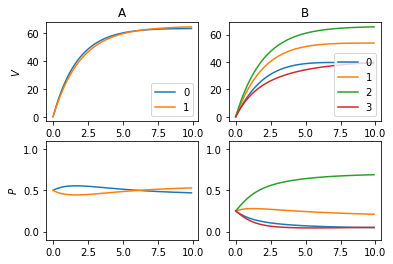

In [37]:
VALUES_OF_A_GIVEN_B = np.array([[100, 60, 62, 64], [60, 62, 66, 70]])
VALUES_OF_B_GIVEN_A = np.array([[70, 69, 66, 10], [10, 40, 66, 68]]).T
ALPHA = 0.95
BETA = 1 - ALPHA
LAMBDA = .1
golman_generalized(VALUES_OF_A_GIVEN_B, VALUES_OF_B_GIVEN_A, \
    ALPHA, BETA, LAMBDA)

Player B ends up playing the non-Nash option (2 above).

With a more Golman-type accumulation, one gets the same qualitative outcome, but reached in fewer time steps:

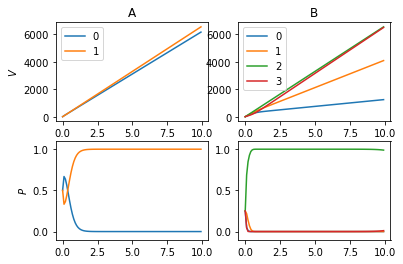

In [38]:
ALPHA = 1
BETA = 1
golman_generalized(VALUES_OF_A_GIVEN_B, VALUES_OF_B_GIVEN_A, \
    ALPHA, BETA, LAMBDA)

## Travellers dilemma

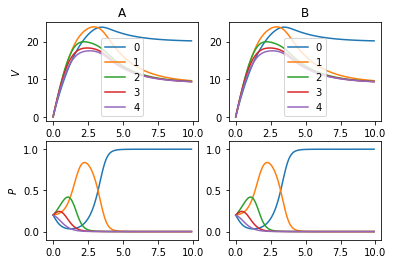

In [39]:
# get payoff matrix   
MIN_BID = 20
MAX_BID = 60
BID_INT = 10
GAMMA = 11
BIDS = np.arange(MIN_BID, MAX_BID+BID_INT, BID_INT)
N_BIDS = len(BIDS)
VALUES = np.zeros((N_BIDS, N_BIDS))
for i_bid_A, bid_A in enumerate(BIDS):
    for i_bid_B, bid_B in enumerate(BIDS):
        if bid_A == bid_B:
            delta = 0
        else:
            delta = math.copysign(GAMMA, bid_B - bid_A)
        VALUES[i_bid_A, i_bid_B] = min(bid_A, bid_B) + delta
        
# model settings
ALPHA = 0.95
BETA = 1 - ALPHA
LAMBDA = 1

# run model
golman_generalized(VALUES, VALUES, ALPHA, BETA, LAMBDA) # symmetric game - same value matrices for both players

The model really nicely "argues" itself down to the Nash equilibrium. Setting a lower $\lambda$, introducing more randomness into the decisions (including in the belief about the other agent's decisions), results in intermediate, non-Nash, actions coming out on top:

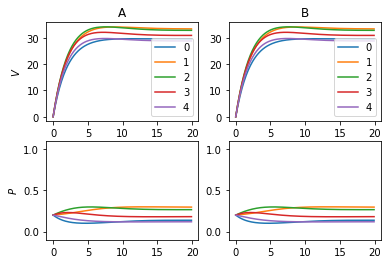

In [40]:
LAMBDA = 0.2
golman_generalized(VALUES, VALUES, ALPHA, BETA, LAMBDA, END_TIME = 20)